# Fractopo – Fracture Network Analysis

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import geopandas as gpd

In [3]:
# This cell's contents only for development purposes.
from importlib.util import find_spec

if find_spec("fractopo") is None:
    import sys

    sys.path.append("../../")

In [4]:
from fractopo.analysis.network import Network
import matplotlib.pyplot as plt

plt.close()

## Data (KB11)

In [5]:
# Trace and target area data available on GitHub
trace_data_url = "https://raw.githubusercontent.com/nialov/fractopo/master/tests/sample_data/KB11/KB11_traces.geojson"
area_data_url = "https://raw.githubusercontent.com/nialov/fractopo/master/tests/sample_data/KB11/KB11_area.geojson"

# Use geopandas to load data from urls
traces = gpd.read_file(trace_data_url)
area = gpd.read_file(area_data_url)

# Name the dataset
name = "KB11"

## Visualizing trace map data

<AxesSubplot:>

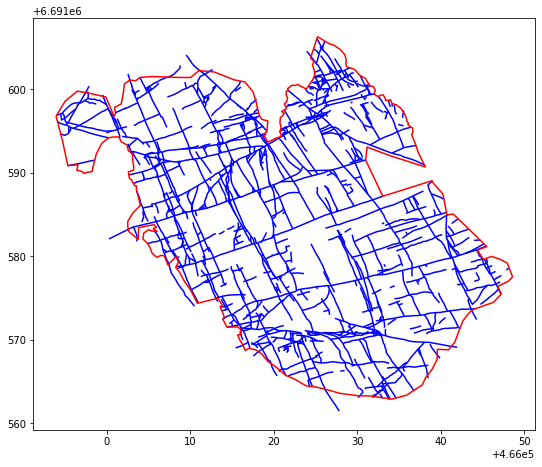

In [6]:
fix, ax = plt.subplots(figsize=(9, 9))
traces.plot(ax=ax, color="blue")
area.boundary.plot(ax=ax, color="red")

## Create Network

In [7]:
# Create Network and automatically determine branches and nodes
kb11_network = Network(
    traces, area, name=name, determine_branches_nodes=True, snap_threshold=0.001
)

## Visualizing branches and nodes

In [8]:
from fractopo.general import CC_branch, CI_branch, II_branch, X_node, Y_node, I_node

# Function to determine color for each branch and node type
def assign_colors(feature_type: str):
    if feature_type in (CC_branch, X_node):
        return "green"
    if feature_type in (CI_branch, Y_node):
        return "blue"
    if feature_type in (II_branch, I_node):
        return "black"
    return "red"

| Branch or Node Type | Color |
|---------------------|-------|
| C - C, X            | Green |
| C - I, Y            | Blue  |
| I - I, I            | Black |
| Other               | Red   |

### Branches

<AxesSubplot:>

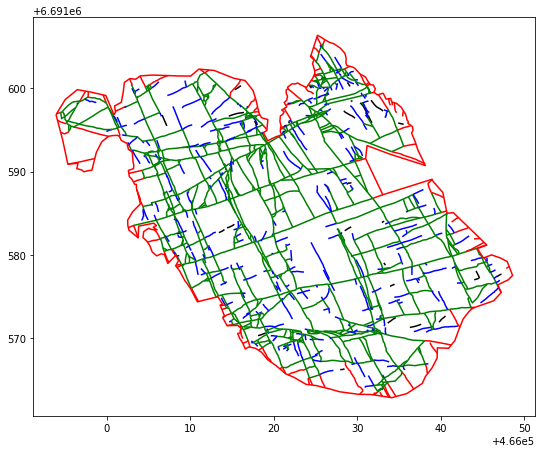

In [9]:
fix, ax = plt.subplots(figsize=(9, 9))
kb11_network.branch_gdf.plot(
    colors=[assign_colors(bt) for bt in kb11_network.branch_types], ax=ax
)
area.boundary.plot(ax=ax, color="red")

### Nodes

<AxesSubplot:>

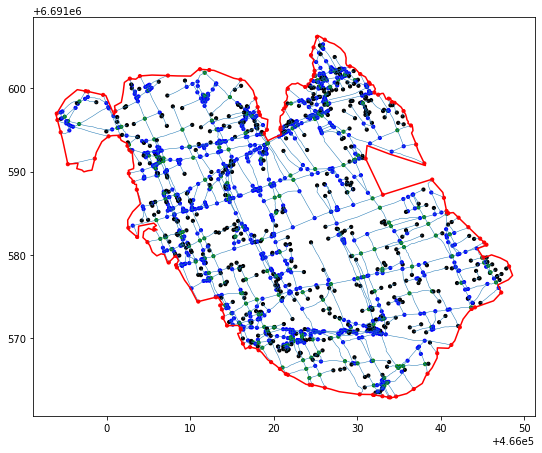

In [10]:
fix, ax = plt.subplots(figsize=(9, 9))
# Traces
kb11_network.trace_gdf.plot(ax=ax, linewidth=0.5)
# Nodes
kb11_network.node_gdf.plot(
    c=[assign_colors(bt) for bt in kb11_network.node_types], ax=ax, markersize=10
)
area.boundary.plot(ax=ax, color="red")

## Rose plots

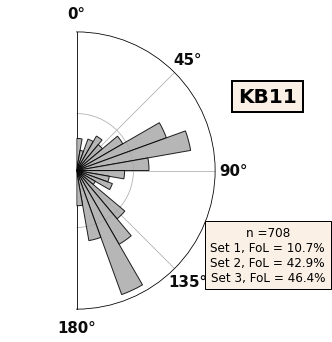

In [11]:
# Plot azimuth rose plot of fracture traces
azimuth_bin_dict, fig, ax = kb11_network.plot_trace_azimuth()

## Length distributions

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


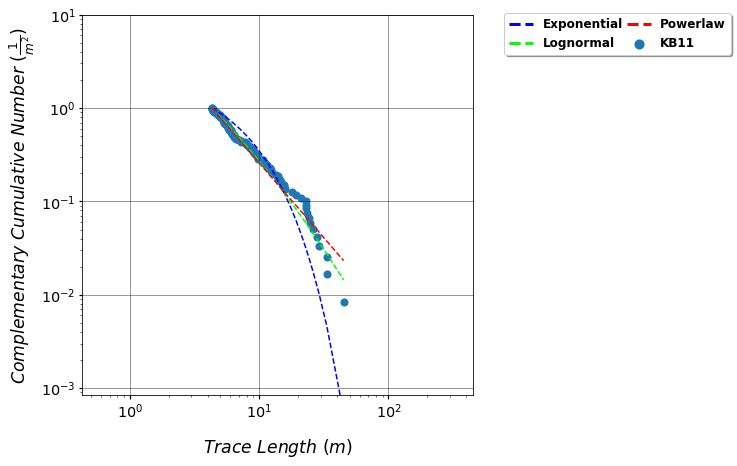

In [12]:
# Plot length distribution fits (powerlaw, exponential and lognormal) of fracture traces
fit, fig, ax = kb11_network.plot_trace_lengths()

In [13]:
# Fit properties
print(f"Automatically determined powerlaw cut-off: {fit.xmin}")
print(f"Powerlaw exponent: {fit.alpha - 1}")
print(
    f"Compare powerlaw fit to lognormal: R, p = {fit.distribution_compare('power_law', 'lognormal')}"
)

Automatically determined powerlaw cut-off: 4.321478841775524
Powerlaw exponent: 1.6051888040287916
Compare powerlaw fit to lognormal: R, p = (-0.6749942925041004, 0.4105159341196074)


## Crosscutting and abutting relationships

In [14]:
# Sets are defaults
print(f"Azimuth set names: {kb11_network.azimuth_set_names}")
print(f"Azimuth set ranges: {kb11_network.azimuth_set_ranges}")

Azimuth set names: ('1', '2', '3')
Azimuth set ranges: ((0, 60), (60, 120), (120, 180))


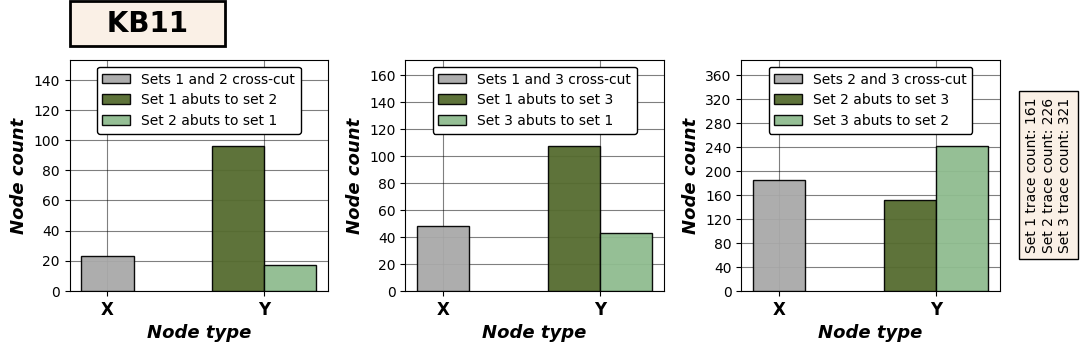

In [15]:
# Plot crosscutting and abutting relationships between azimuth sets
figs, fig_axes = kb11_network.plot_azimuth_crosscut_abutting_relationships()

## Node and branch proportions

In [16]:
kb11_network.node_counts

{'X': 270, 'Y': 824, 'I': 478, 'E': 114}

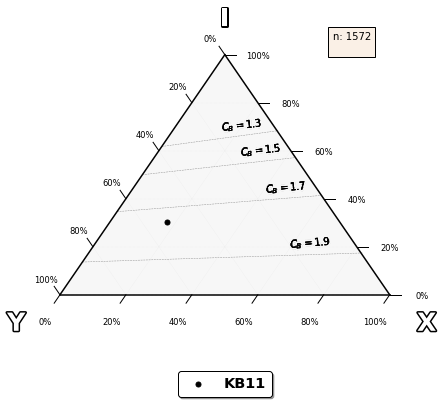

In [17]:
# Plot ternary XYI-node proportion plot
fig, ax, tax = kb11_network.plot_xyi()

In [18]:
kb11_network.branch_counts

{'C - C': 1521,
 'C - I': 410,
 'I - I': 28,
 'C - E': 100,
 'I - E': 12,
 'E - E': 1}

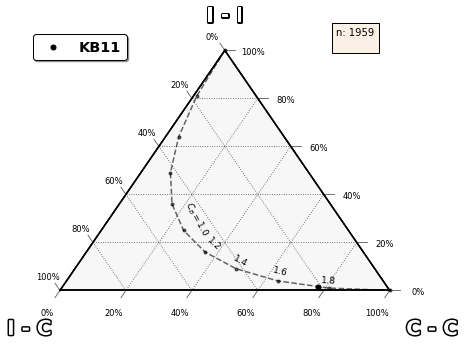

In [19]:
# Plot ternary branch (C-C, C-I, I-I) proportion plot
fig, ax, tax = kb11_network.plot_branch()

## Geometric and topological parameters

In [20]:
kb11_network.parameters

{'Number of Traces': 651.0,
 'Number of Branches': 2015.0,
 'Fracture Intensity B21': 1.2633728710290455,
 'Fracture Intensity P21': 1.2633728710290455,
 'Areal Frequency P20': 0.5258904658323919,
 'Areal Frequency B20': 1.627756203766927,
 'Trace Mean Length': 2.208940309504849,
 'Branch Mean Length': 0.7761437911312323,
 'Dimensionless Intensity P22': 2.7907152607509293,
 'Dimensionless Intensity B22': 0.9805590097328328,
 'Connections per Trace': 3.3609831029185866,
 'Connections per Branch': 1.7627791563275435,
 'Fracture Intensity (Mauldon)': 1.4357438039436288,
 'Fracture Density (Mauldon)': 0.5258904658323919,
 'Trace Mean Length (Mauldon)': 2.7301194777720483,
 'Connection Frequency': 0.8837544848243267}